In [1]:
import torch
import gpytorch as gp
import math
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# define stuff for 1
l = 20
a2 = 5
X = torch.Tensor(range(1, 101)).view(100, 1)

# 1

### a

In [3]:
class ExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,
                 kernel=gp.kernels.RBFKernel(), l=20, a=5):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        # create scale kernel surrounding the kernel passed in
        kernel = gp.kernels.ScaleKernel(kernel)
        # set initial a/L values
        kernel.outputscale = a
        kernel.base_kernel.lengthscale = l
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

class NoScaleExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,
                 kernel=gp.kernels.RBFKernel(), l=20):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        # no scaling
        kernel.lengthscale = l
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

class OUKernel(gp.kernels.Kernel):
    
    has_lengthscale = True

    def __init__(self, **kwargs):
        super(OUKernel, self).__init__(has_lengthscale=True, **kwargs)

    def forward(self, x1, x2, diag=False, **params):
        # calculate using OU formula from homework
        x1_ = x1.div(self.lengthscale ** (0.5))
        x2_ = x2.div(self.lengthscale ** (0.5))
        diff = self.covar_dist(x1_,
                               x2_,
                               diag=diag,
                               **params)
        res = diff.mul(-1).exp_()
        return res

# init periodic kernel separately because it is special
per_kernel = gp.kernels.PeriodicKernel()
per_kernel.period_length = (2 * math.pi)
kernels = {'RBF': gp.kernels.RBFKernel(),
           'ARD': gp.kernels.RBFKernel(ard_num_dims=X.shape[1]),
           'OU': OUKernel(),
           'PER': per_kernel,
           'RQ': gp.kernels.RQKernel()
           }

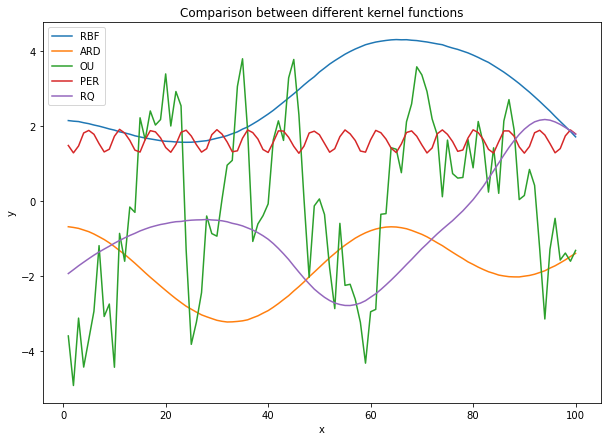

In [4]:
plt.figure(figsize=(10, 7))
# create a model with each kernel and sample once from the (untrained) prior, then plot
for kernel_name, kernel in kernels.items():
    likelihood = gp.likelihoods.GaussianLikelihood()
    model = ExactGPModel(None, None, likelihood, kernel)
    model.eval()
    samples = model(X).sample(sample_shape=torch.Size((1,)))

    for sample in samples:
        plt.plot(X, sample, label=kernel_name)
plt.title('Comparison between different kernel functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best');

### b

The kernel hyperparameters $\ell, a^2, \alpha$ all represent different things for the functions sampled from the prior.

$\ell$, the *lengthscale*, represents how far a function's autocovariance reaches, i.e. it represents the strength of correlation between two function values that are close to each other. The larger the lengthscale, the more correlated, and the further that autocorrelation can reach. For instance, if we take a large enough lengthscale, then the correlation between the values $f(x=1)$ and $f(x=100)$ might be correlated, whereas if we take a small enough lengthscale then even the samples $f(x=10)$ and $f(x=11)$ will be uncorrelated.

Analytically analyzing $\ell$ also displays this trait: For small $\ell$, we have a relatively small factors in the exponent part of the kernel, which leads to very small covariances even between inputs that are not that far apart, whereas with larger $\ell$ we have larger numbers in the exponent part of the kernel, which yields larger covariances for inputs that are far apart.

$a^2$, the *scale*, represents how varied the overall scale of $f$ is. For a very low scale, $f$ will be in a short range of e.g. -1 to 1, whereas for a large scale, $f$ will vary in magnitude a lot, e.g. -40 to 40.

Analytically analyzing $a^2$ shows this: The larger $a^2$, the larger the covariance between two nearby inputs, since it is a direct multiplier of the exponent part of the kernel.

$\alpha$ is a parameter specific to the RQ kernel. It represents how "smooth" the function $f$ is: for very low values of $\alpha$, $f$ is very smooth, whereas for high values $f$ is far more jagged. In a sense, it controls the covariance difference for the nearest neighbors of the input.

Analytically analyzing $\alpha$, we see that it is only present in the RQ kernel. The larger we make $\alpha$, the smaller the magnitude of the overall covariance, and thus a lower covariance between near neighbors.

This is demonstrated empirically in the graphs below.

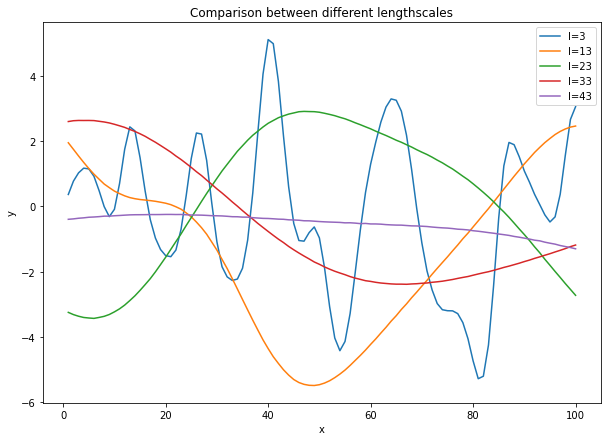

In [5]:
# varying kernel hyperparameters
plt.figure(figsize=(10, 7))

# different L's
for l in range(3, 53, 10):
    likelihood = gp.likelihoods.GaussianLikelihood()
    model = ExactGPModel(None, None, likelihood, l=l)
    model.eval()
    samples = model(X).sample(sample_shape=torch.Size((1,)))
    for sample in samples:
        plt.plot(X, sample, label=f'l={l}')
plt.title('Comparison between different lengthscales')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y');

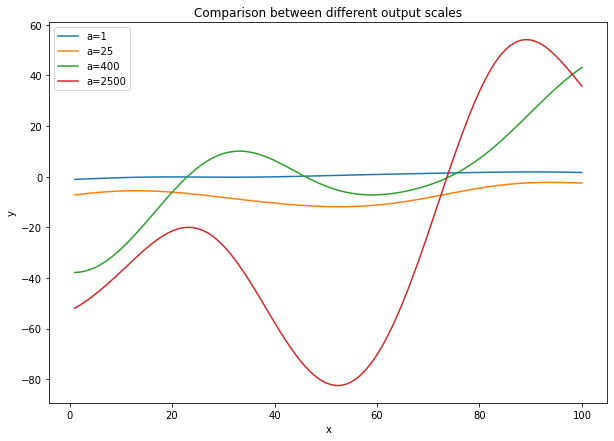

In [6]:
plt.figure(figsize=(10, 7))

# different a's
for a in [1, 5, 20, 50]:
    likelihood = gp.likelihoods.GaussianLikelihood()
    model = ExactGPModel(None, None, likelihood, a=a ** 2)
    model.eval()
    samples = model(X).sample(sample_shape=torch.Size((1,)))
    for sample in samples:
        plt.plot(X, sample, label=f'a={a ** 2}')
plt.title('Comparison between different output scales')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y');

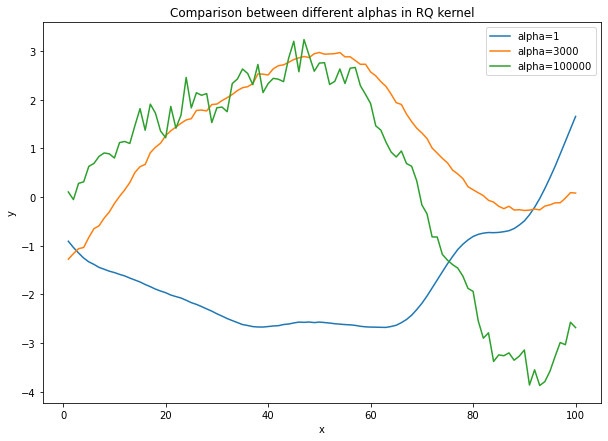

In [7]:
plt.figure(figsize=(10, 7))

# different alpha's
for alpha in [1, 3000, 100000]:
    kernel = gp.kernels.RQKernel()
    kernel.alpha = alpha
    likelihood = gp.likelihoods.GaussianLikelihood()
    model = ExactGPModel(None, None, likelihood, kernel=kernel)
    model.eval()
    samples = model(X).sample(sample_shape=torch.Size((1,)))
    for sample in samples:
        plt.plot(X, sample, label=f'alpha={alpha}')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison between different alphas in RQ kernel');

# 2

In [8]:
from scipy.io import loadmat
import numpy as np

# load dataset and define function
data = loadmat('data/datatest.mat')
x = torch.Tensor(data['x']).squeeze()
xstar = torch.Tensor(data['xstar']).squeeze()
y = torch.Tensor(data['y']).squeeze()

def f(x):
    return x + x ** 2 - 14 * x ** 3 + x ** 4 + 1000 * np.cos(x)

In [9]:
# set a/L according to homework
a = y.var()
l = 5
# subtract empirical mean since we assume it is mean 0
empirical_mean = y.mean()
y_zero_centered = y - empirical_mean

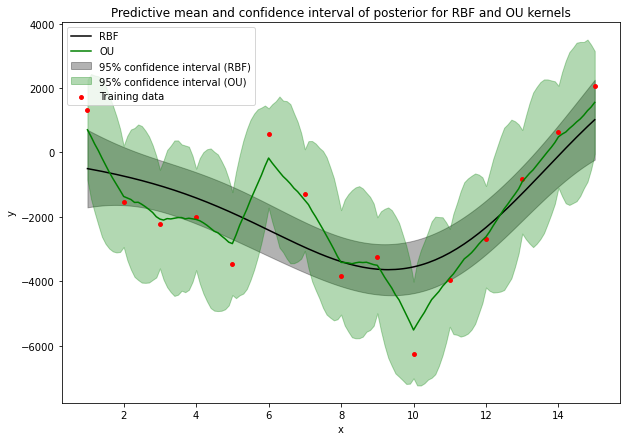

In [10]:
likelihood = gp.likelihoods.GaussianLikelihood()
# set the noise level
likelihood.noise_covar.noise = 900 ** 2

kernels = {'RBF': gp.kernels.RBFKernel(), 'OU': OUKernel()}

plt.figure(figsize=(10, 7))

# for each of RBF and OU kernels, create the model and get a 95% confidence interval
for kernel_name, kernel in kernels.items():
    model = ExactGPModel(x,
                         y_zero_centered,
                         likelihood,
                         kernel=kernel,
                         a=a,
                         l=l,
                         )
    model.eval()
    preds = model(xstar)
    samples = preds.sample(sample_shape=torch.Size((1000,)))
    
    # get 2 STD's away as confidence interval. must add empirical mean since it was subtracted earlier
    predictive_mean = samples.mean(axis=0) + empirical_mean
    lower = predictive_mean - 2 * samples.std(axis=0)
    upper = predictive_mean + 2 * samples.std(axis=0)

    # plot the mean in "full" color
    plt.plot(xstar,
             predictive_mean,
             label=f'{kernel_name}',
             color='k' if kernel_name == 'RBF' else 'g',
             )

    # plot the confidence interval with lower alpha
    plt.fill_between(xstar,
                     lower,
                     upper,
                     color='k' if kernel_name == 'RBF' else 'g',
                     alpha=0.3,
                     label=f'95% confidence interval ({kernel_name})',
                     )

# plot the training data
plt.scatter(x, y, s=15, color='r', label='Training data')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predictive mean and confidence interval of posterior for RBF and OU kernels');

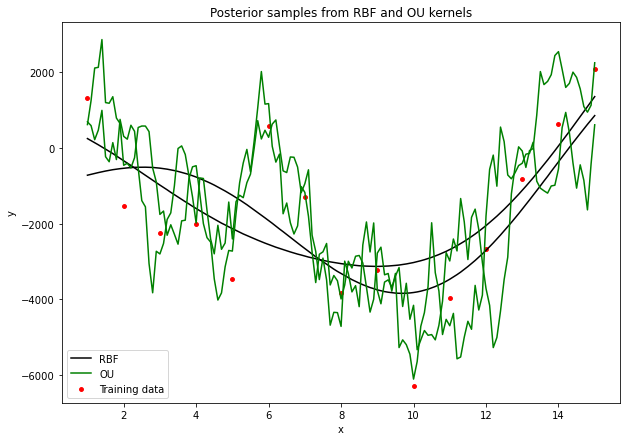

In [11]:
likelihood = gp.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = 900 ** 2

kernels = {'RBF': gp.kernels.RBFKernel(), 'OU': OUKernel()}

plt.figure(figsize=(10, 7))

# again, for each kernel
for kernel_name, kernel in kernels.items():
    model = ExactGPModel(x,
                         y_zero_centered,
                         likelihood,
                         kernel=kernel,
                         a=a,
                         l=l,
                         )
    model.eval()
    preds = model(xstar)
    # take two samples from the posterior
    samples = preds.sample(sample_shape=torch.Size((2,)))

    # plot them
    for idx, sample in enumerate(samples):
        # don't forget to add the empirical mean back
        plt.plot(xstar,
                 sample + empirical_mean,
                 label=f'{kernel_name}' if idx == 0 else '',
                 color='k' if kernel_name == 'RBF' else 'g',
                 )
plt.scatter(x, y, s=15, color='r', label='Training data')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Posterior samples from RBF and OU kernels');

# 3

### a

In [ ]:
# rbf
likelihood = gp.likelihoods.GaussianLikelihood().train()
model = ExactGPModel(x, y_zero_centered, likelihood).train()
ml = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

old_loss = np.inf
loss = 0
step = 0

# train model until loss difference between iterations is less than 1e-2
while abs(old_loss - loss) > 1e-2:
    step += 1
    optimizer.zero_grad()
    output = model(x)
    
    old_loss = loss
    # calculate loss
    loss = - ml(output, y_zero_centered)
    # backprop
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f'Iter {step:5d} - Loss: {loss.item():.3f} '
              f'L: {model.covar_module.base_kernel.lengthscale.item()}, '
              f'a: {model.covar_module.outputscale.item()}, '
              f'noise: {model.likelihood.noise.item():.3f}')    

*output from above*

Iter 115000 - Loss: 1082.431 L: 0.8947250843048096, a: 1049.70361328125, noise: 943.334

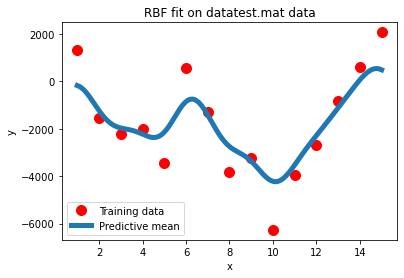

In [13]:
# switch to eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    # get predictions
    true_pred = model(xstar)
    noisy_pred = likelihood(true_pred)

# calculate mean
mean = noisy_pred.mean

# plot datapoints and predictive mean
plt.plot(x, y, 'ro', ms=10, label='Training data')
plt.plot(xstar, mean + empirical_mean, lw=5, label='Predictive mean')
plt.xlabel('x')
plt.ylabel('y')
plt.title('RBF fit on datatest.mat data')
plt.legend(loc='best');

In [ ]:
# OU
# same as above, but with OU kernel instead of RBF
likelihood = gp.likelihoods.GaussianLikelihood().train()
model = ExactGPModel(x, y_zero_centered, likelihood, kernel=OUKernel()).train()
ml = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

old_loss = np.inf
loss = 0
step = 0

while abs(old_loss - loss) > 1e-2:
    step += 1
    optimizer.zero_grad()
    output = model(x)
    
    old_loss = loss
    loss = - ml(output, y_zero_centered)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f'Iter {step:5d} - Loss: {loss.item():.3f} '
              f'L: {model.covar_module.base_kernel.lengthscale.item()}, '
              f'a: {model.covar_module.outputscale.item()}, '
              f'noise: {model.likelihood.noise.item():.3f}')    

*output from above*

Iter 115000 - Loss: 1075.290 L: 1.301035761833191, a: 1025.27001953125, noise: 1003.987

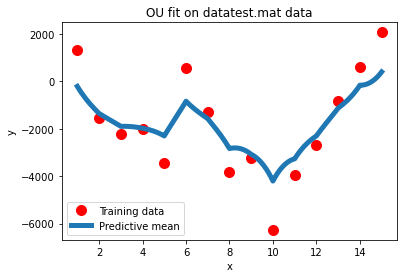

In [15]:
model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    true_pred = model(xstar)
    noisy_pred = likelihood(true_pred)

mean = noisy_pred.mean

plt.plot(x, y, 'ro', ms=10, label='Training data')
plt.plot(xstar, mean + empirical_mean, lw=5, label='Predictive mean')
plt.xlabel('x')
plt.ylabel('y')
plt.title('OU fit on datatest.mat data')
plt.legend(loc='best');

For the RBF kernel, there is a far more granular approach in the learned kernel: the lengthscale is much shorter. This is because the LML of the shorter lengthscale, with less noise, is greater than that of the longer lengthscale with more noise. This is likely due to the two big "outlier" datapoints at $x \approx 6$ and $x \approx 10$. They are obviously very different for the learned kernel.

There isn't a lot of difference between the learned OU kernel and the kernel used in (2). This is likely because the kernel used in (2) was already able to fit the "outlier" datapoints mentioned a lot better, since it can have less covariance between neighboring datapoints.

### b

In [16]:
# load 2d data
data = loadmat('data/2dfunc.mat')
x = torch.Tensor(data['x']).squeeze()
y = torch.Tensor(data['y']).squeeze()

In [17]:
x.shape, y.shape

(torch.Size([121, 2]), torch.Size([121]))

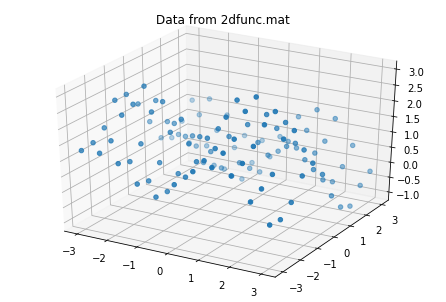

In [18]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = mplot3d.Axes3D(fig)

# create a scatter plot in 3d of the data, with y values in the up/down direction
ax.scatter(x[:, 0], x[:, 1], y)
plt.title('Data from 2dfunc.mat');

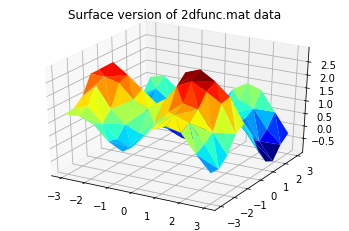

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot the data as a surface
# looks oddly RBF-like...
ax.plot_trisurf(x[:, 0], x[:, 1], y, cmap=plt.cm.jet, linewidth=0.1)
plt.title('Surface version of 2dfunc.mat data');

In [20]:
# subtract empirical mean
empirical_mean = y.mean()
y_zero_centered = y - empirical_mean

likelihood = gp.likelihoods.GaussianLikelihood().train()
# create ARD kernel with no scale
model = NoScaleExactGPModel(x,
                            y_zero_centered,
                            likelihood,
                            kernel=gp.kernels.RBFKernel(ard_num_dims=x.shape[1]),
                            l=1,
                            ).train()
ml = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

old_loss = np.inf
loss = 0
step = 0

# train until converged
while abs(old_loss - loss) > 1e-4:
    step += 1
    optimizer.zero_grad()
    output = model(x)
    
    old_loss = loss
    loss = - ml(output, y_zero_centered)
    # backprop
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f'Iter {step:5d} - Loss: {loss.item():.3f} '
              f'L: {model.covar_module.lengthscale.detach().numpy()}, '
              f'noise: {model.likelihood.noise.item():.3f}')
# final results    
print(f'Iter {step:5d} - Loss: {loss.item():.3f} '
      f'L: {model.covar_module.lengthscale.detach().numpy()}, '
      f'noise: {model.likelihood.noise.item():.3f}')
print(f'Likelihood: {- loss.item()}')

Iter   543 - Loss: -0.164 L: [[1.4510943 1.3201793]], noise: 0.013
Likelihood: 0.16351066529750824


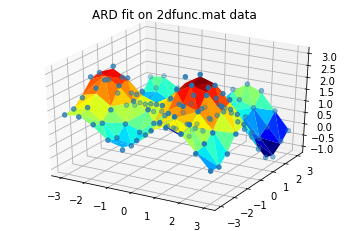

In [21]:
model.eval()
likelihood.eval()

# get predictive mean in eval mode
with torch.no_grad(), gp.settings.fast_pred_var():
    true_pred = model(x)
    noisy_pred = likelihood(true_pred)

mean = noisy_pred.mean

# plot original data points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)

# plot the predictive mean
ax.plot_trisurf(x[:, 0], x[:, 1], mean + empirical_mean, cmap=plt.cm.jet, linewidth=0.1)
plt.title('ARD fit on 2dfunc.mat data');

In [22]:
# same as above but with RBF kernel
likelihood = gp.likelihoods.GaussianLikelihood().train()
model = NoScaleExactGPModel(x,
                            y_zero_centered,
                            likelihood,
                            kernel=gp.kernels.RBFKernel(),
                            l=1,
                            ).train()
ml = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

old_loss = np.inf
loss = 0
step = 0

while abs(old_loss - loss) > 1e-4:
    step += 1
    optimizer.zero_grad()
    output = model(x)
    
    old_loss = loss
    loss = - ml(output, y_zero_centered)
    loss.backward()
    
    if step % 1000 == 0:
        print(f'Iter {step:5d} - Loss: {loss.item():.3f} '
              f'L: {model.covar_module.lengthscale.item()}, '
              f'noise: {model.likelihood.noise.item():.3f}')
    optimizer.step()
print(f'Iter {step:5d} - Loss: {loss.item():.3f} '
      f'L: {model.covar_module.lengthscale.detach().numpy().item()}, '
      f'noise: {model.likelihood.noise.item():.3f}')
print(f'Likelihood: {- loss.item()}')

Iter   531 - Loss: -0.158 L: 1.4068496227264404, noise: 0.014
Likelihood: 0.15769429504871368


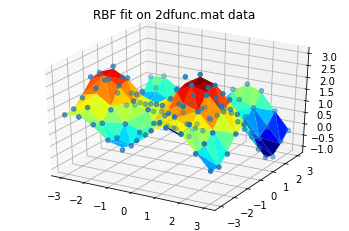

In [23]:
model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    true_pred = model(x)
    noisy_pred = likelihood(true_pred)

mean = noisy_pred.mean

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)

ax.plot_trisurf(x[:, 0], x[:, 1], mean + empirical_mean, cmap=plt.cm.jet, linewidth=0.1)
plt.title('RBF fit on 2dfunc.mat data');

In [24]:
L_sum = 0.1635 + 0.1577
factor = 100 / L_sum

print(f'Relative probability of ARD is {factor * 0.1635}')
print(f'Relative probability of RBF is {factor * 0.1577}')

Relative probability of ARD is 50.90286425902864
Relative probability of RBF is 49.09713574097135


Both fits are very good. The ARD fit has slightly different lengthscales per axis, but both of them are very close to the lengthscale found by the RBF kernel.

Neither of the fits indicate that there's a lot of noise in the data (it's approximately $0.013$).

The relative probability of each model can be calculated through the likelihood each fit output:

$$
L_{ARD} \cdot \dfrac{100}{L_{ARD} + L_{RBF}} = p(ARD)_{relative}
$$

Plugging in the numbers from above:

$$
0.1635 \cdot \dfrac{100}{0.1635 + 0.1577} = p(ARD)_{relative} \approx 50.9\%
$$

$$
0.1577 \cdot \dfrac{100}{0.1635 + 0.1577} = p(RBF)_{relative} \approx 49.1\%
$$

Thus it's slightly more likely (approx. 50.9% chance) that the ARD kernel was the original data generator.

$$\square$$

# 4

In [25]:
# load airline data
data = loadmat('data/airline.mat')
x_train = torch.Tensor(data['xtrain']).squeeze()
y_train = torch.Tensor(data['ytrain'].astype(int)).squeeze()
x_test = torch.Tensor(data['xtest']).squeeze()
y_test = torch.Tensor(data['ytest'].astype(int)).squeeze()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([96]) torch.Size([96]) torch.Size([48]) torch.Size([48])


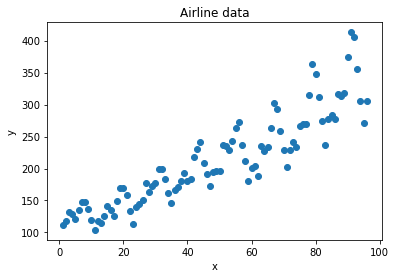

In [26]:
# visualize the data so we have some idea of what kernel to use
plt.scatter(x_train, y_train)
plt.title('Airline data')
plt.xlabel('x')
plt.ylabel('y');

In [27]:
# extrapolating 20 years into the future
x_extrapolated = torch.range(x_train[0], x_train[-1] + 20 * 12 + 1)

In [ ]:
# custom class so it doesn't mess up stuff in other cells
class AirlineExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,
                 kernel=gp.kernels.RBFKernel()):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

# subtract empirical mean
empirical_mean = y_train.mean()
y_train_zero_centered = y_train - empirical_mean

# create combination of 4 kernels: RBF, PER, POLY, RQ
kernel_1 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
kernel_2 = gp.kernels.ScaleKernel(gp.kernels.PeriodicKernel())
kernel_3 = gp.kernels.ScaleKernel(gp.kernels.PolynomialKernel(power=1))
kernel_4 = gp.kernels.ScaleKernel(gp.kernels.RQKernel())
kernel = ((kernel_1 +
          kernel_2) +
          (kernel_3 +
          kernel_4)
          )
likelihood = gp.likelihoods.GaussianLikelihood().train()

# create the model
model = AirlineExactGPModel(x_train, y_train_zero_centered, likelihood, kernel=kernel).train()
ml = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

step = 0
old_loss = np.inf
loss = 0

# train until converged
while abs(old_loss - loss) > 1e-4:
    step += 1
    optimizer.zero_grad()
    output = model(x_train)
    
    old_loss = loss
    loss = - ml(output, y_train_zero_centered)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f'Iter {step} - Loss: {loss.item():.3f}\n  '
              f'L_rb: {model.covar_module.kernels[0].kernels[0].base_kernel.lengthscale.item():.4f}, '
              f'L_pr: {model.covar_module.kernels[0].kernels[1].base_kernel.lengthscale.item():.4f}, '
              f'O_py: {model.covar_module.kernels[1].kernels[0].base_kernel.raw_offset.item():.4f}, '
              f'L_rq: {model.covar_module.kernels[1].kernels[1].base_kernel.lengthscale.item():.4f}, '
              f'a_rb: {model.covar_module.kernels[0].kernels[0].outputscale.item():.4f}, '
              f'a_pr: {model.covar_module.kernels[0].kernels[1].outputscale.item():.4f}, '
              f'a_py: {model.covar_module.kernels[1].kernels[0].outputscale.item():.4f}, '
              f'a_rq: {model.covar_module.kernels[1].kernels[1].outputscale.item():.4f}, '
              f'noise: {model.likelihood.noise.item():.3f}')
# print the final parameter values    
print(f'Iter {step} - Loss: {loss.item():.3f}\n  '
      f'L_rb: {model.covar_module.kernels[0].kernels[0].base_kernel.lengthscale.item():.4f}, '
      f'L_pr: {model.covar_module.kernels[0].kernels[1].base_kernel.lengthscale.item():.4f}, '
      f'O_py: {model.covar_module.kernels[1].kernels[0].base_kernel.raw_offset.item():.4f}, '
      f'L_rq: {model.covar_module.kernels[1].kernels[1].base_kernel.lengthscale.item():.4f}, '
      f'a_rb: {model.covar_module.kernels[0].kernels[0].outputscale.item():.4f}, '
      f'a_pr: {model.covar_module.kernels[0].kernels[1].outputscale.item():.4f}, '
      f'a_py: {model.covar_module.kernels[1].kernels[0].outputscale.item():.4f}, '
      f'a_rq: {model.covar_module.kernels[1].kernels[1].outputscale.item():.4f}, '
      f'noise: {model.likelihood.noise.item():.3f}')

*output from above*

Iter 22049 - Loss: 4.289
  L_rb: 1.7715, L_pr: 0.0466, O_py: 0.7852, L_rq: 1.7647, a_rb: 87.3208, a_pr: 106.2056, a_py: 4.6229, a_rq: 86.5505, noise: 49.365

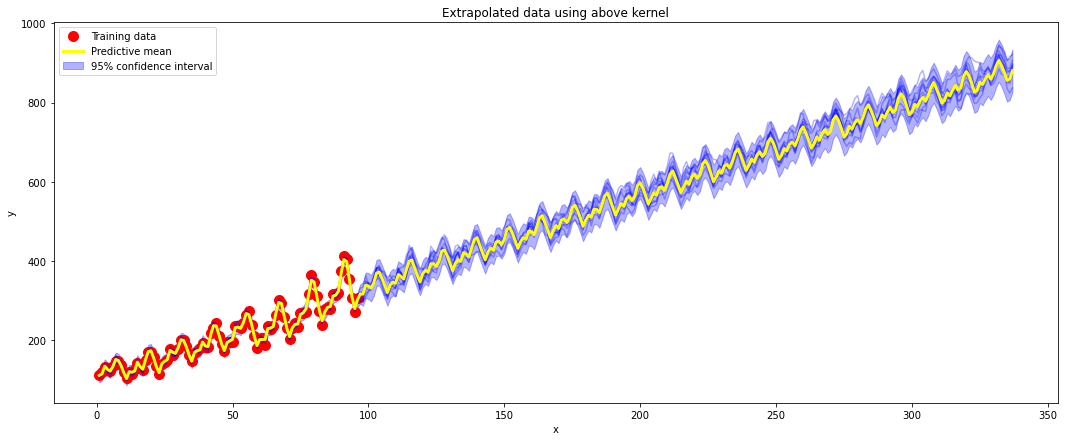

In [29]:
model.eval()
likelihood.eval()
# get predictions in eval mode
preds = model(x_extrapolated)
samples = preds.sample(sample_shape=torch.Size([10]))

with torch.no_grad(), gp.settings.fast_pred_var():
    true_pred = model(x_extrapolated)
    noisy_pred = likelihood(true_pred)

# get confidence region
lower, upper = noisy_pred.confidence_region()
mean = noisy_pred.mean

lower += empirical_mean
upper += empirical_mean
mean += empirical_mean

# plot the training data, predictive mean and 95% confidence interval
plt.figure(figsize=(18, 7))
plt.plot(x_train, y_train, 'ro', ms=10, label='Training data')
plt.fill_between(x_extrapolated, lower, upper, color='b', alpha=0.3, label='95% confidence interval')

# plot a few samples from the posterior
for sample in samples:
    plt.plot(x_extrapolated, sample + empirical_mean, color='b', alpha=0.3)

# plot the predictive mean last so it shows up better
plt.plot(x_extrapolated, mean, lw=3, color='#FFFF00', label='Predictive mean')

plt.title('Extrapolated data using above kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best');

In [30]:
from sklearn.metrics import mean_squared_error

model.eval()
likelihood.eval()

with torch.no_grad(), gp.settings.fast_pred_var():
    true_pred = model(x_test)
    noisy_pred = likelihood(true_pred)

# calc RMSE using the predictive mean
mean_squared_error(y_test, noisy_pred.mean)

62985.78

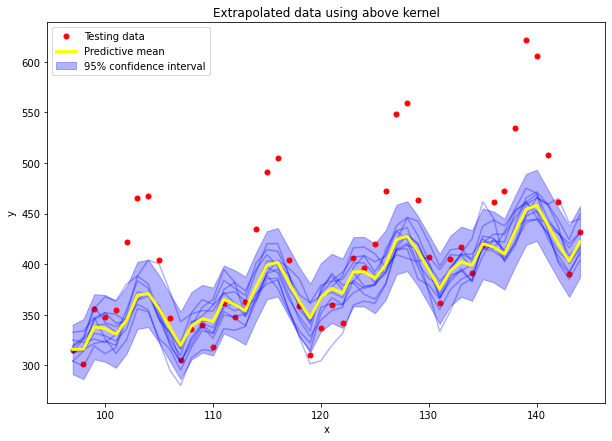

In [31]:
model.eval()
likelihood.eval()
# plot the same as above but only for the test data
preds = model(x_test)
samples = preds.sample(sample_shape=torch.Size([10]))

with torch.no_grad(), gp.settings.fast_pred_var():
    true_pred = model(x_test)
    noisy_pred = likelihood(true_pred)

lower, upper = noisy_pred.confidence_region()
mean = noisy_pred.mean

lower += empirical_mean
upper += empirical_mean
mean += empirical_mean

plt.figure(figsize=(10, 7))

plt.plot(x_test, y_test, 'ro', ms=5, label='Testing data')
plt.fill_between(x_test, lower, upper, color='b', alpha=0.3, label='95% confidence interval')

for sample in samples:
    plt.plot(x_test, sample + empirical_mean, color='b', alpha=0.3)

# again plotting it last for viz purposes
plt.plot(x_test, mean, lw=3, color='#FFFF00', label='Predictive mean')

plt.title('Extrapolated data using above kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best');

I used a combination of four kernels: RBF, Periodic, Polynomial and RQ. These were chosen because:

- RBF: smoothness of the resulting kernel
- Periodic: The airline data has periodicity on a per-year basis (more flights around holidays, for instance)
- Polynomial: There is an increasing trend in the data
- RQ: There is a lot of very quick variability in the data (little correlation between neighboring points)

Ideally, I would have used a `power=2` polynomial kernel (or even greater - but I suspect 2 is enough), but I was having trouble getting the model to train since it was raising a `NotPSDError`:

```
NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(53,53) is zero, singular U.
```

I was not able to resolve this error, and could not find a suitable solution online or on the GPyTorch documentation.

The model does not fit the data extremely well. It learns the underlying trend and that there is periodicity to it, but the trend line is off (since it's just a straight line and does not curve further upwards). It also doesn't fit the peaks of the periodicity very well.

Fitting the same as above but with `PolynomialKernel(power=1.5)` does have the further increasing trend I wanted, but it fits the local noise very badly.

An alternate idea I had was to multiply the polynomial and periodic kernels together (since the ups/downs are far greater magnitude the greater that `x` is) but this also ran into the `NotPSDError`.